# Project Code

### Exploratory Data Analysis

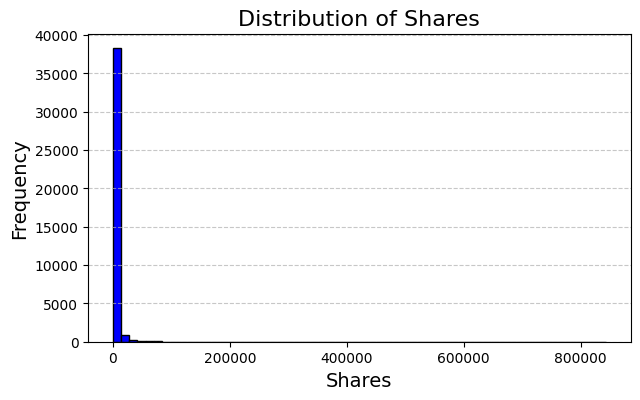

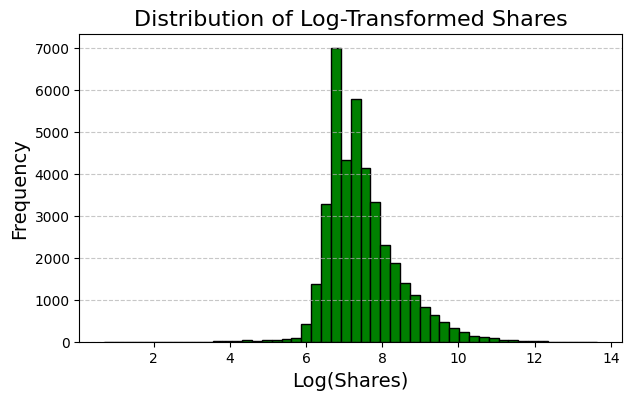

                          Feature   Coefficient
37                         LDA_00  4.780803e+01
41                         LDA_04  4.758572e+01
40                         LDA_03  4.745997e+01
38                         LDA_01  4.743783e+01
39                         LDA_02  4.735159e+01
45     global_rate_negative_words  5.559747e-01
42            global_subjectivity  4.071255e-01
46            rate_positive_words  2.800920e-01
2                 n_unique_tokens  1.855607e-01
14         data_channel_is_socmed  1.581065e-01
36                     is_weekend  1.514275e-01
56         abs_title_subjectivity  1.414184e-01
47            rate_negative_words  1.202541e-01
15           data_channel_is_tech  1.001586e-01
53          max_negative_polarity  8.373113e-02
55       title_sentiment_polarity  8.185075e-02
3                n_non_stop_words  7.966317e-02
34            weekday_is_saturday  7.756580e-02
35              weekday_is_sunday  7.386260e-02
54             title_subjectivity  5.860

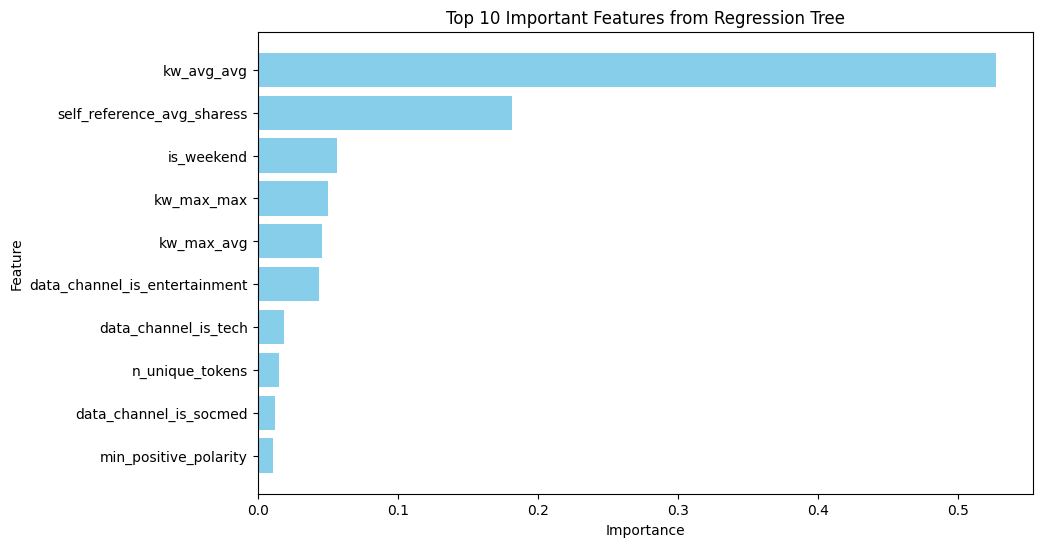

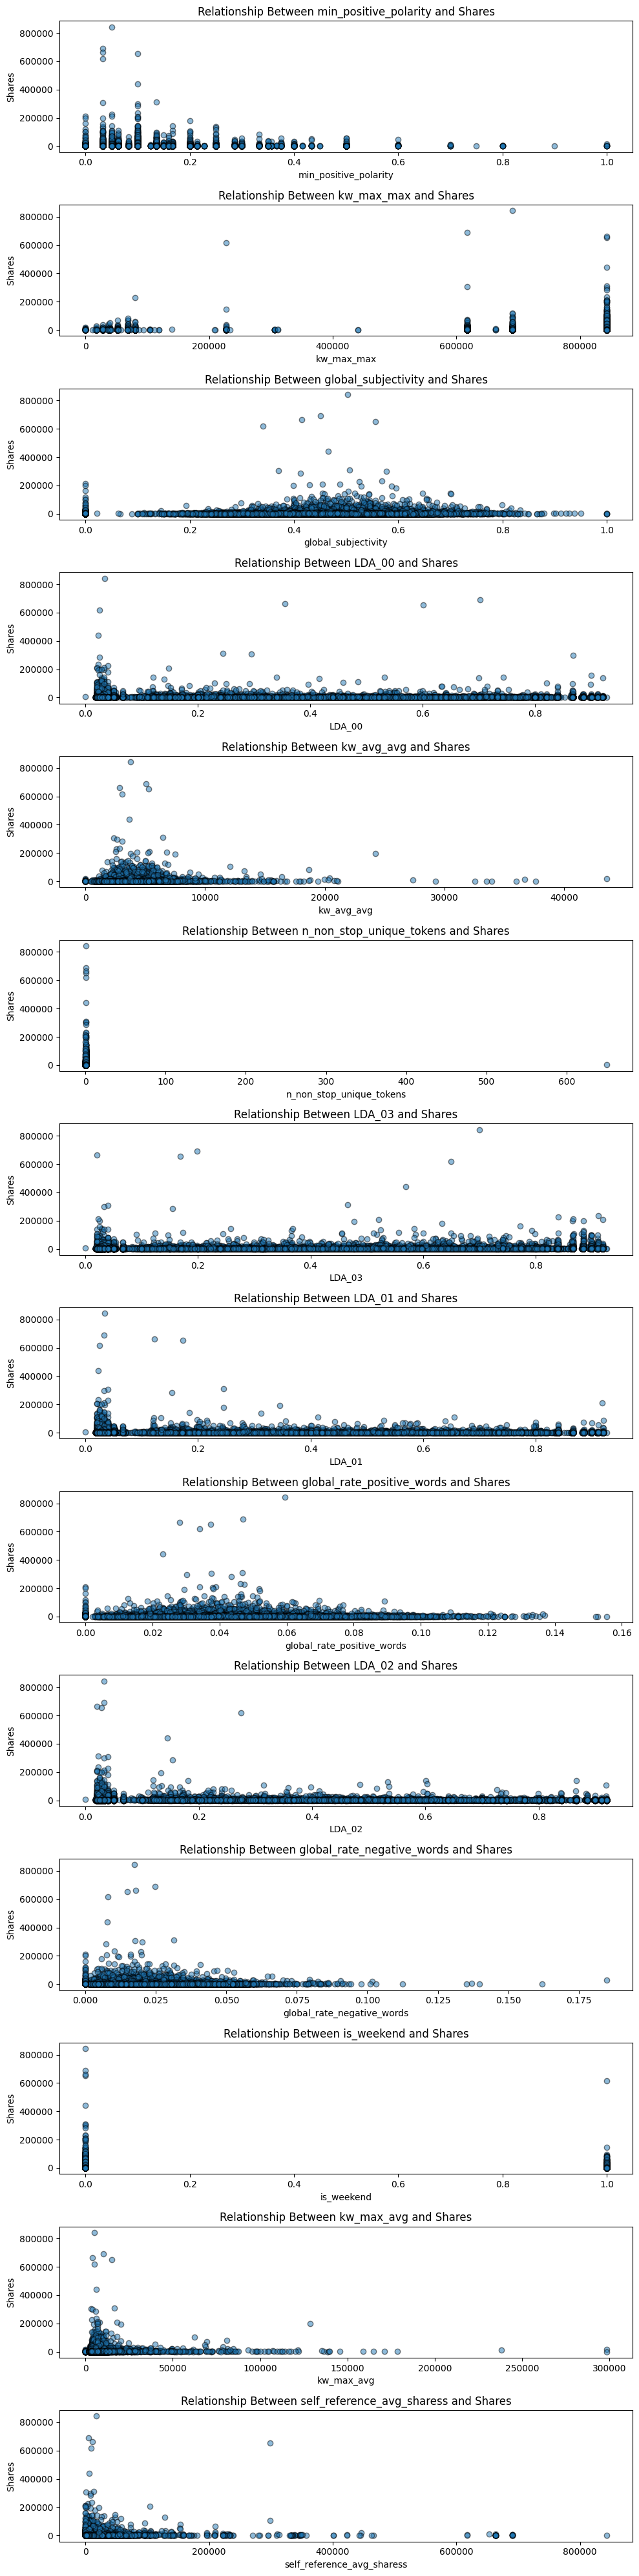

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

news_data = pd.read_csv("https://richardson.byu.edu/220/OnlineNewsPopularity.csv")

#It looked like each column had a ' ' character at the beginning of each word so i strip the spaces here.
news_data.columns = news_data.columns.str.strip()

plt.figure(figsize=(7, 4))
plt.hist(news_data['shares'], bins=60, color='blue', edgecolor='black')
plt.title('Distribution of Shares', fontsize=16)
plt.xlabel('Shares', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Log transformation to make the data less skewed
news_data['shares_log'] = np.log1p(news_data['shares'])

# Transformed data
plt.figure(figsize=(7, 4))
plt.hist(news_data['shares_log'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Log-Transformed Shares', fontsize=16)
plt.xlabel('Log(Shares)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

y = news_data['shares_log']
X = pd.get_dummies(news_data.drop(['shares', 'shares_log', 'url', 'timedelta'], axis=1), drop_first=True)

# Convert categorical variables to dummy/one-hot encoding (if any exist)
X = pd.get_dummies(X, drop_first=True)

# Fit a linear regression model using sklearn
model = LinearRegression()
model.fit(X, y)

# Get coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coefficients.sort_values(by='Coefficient', ascending=False))

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
reg_tree.fit(X, y)

# Identify important predictors
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': reg_tree.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the most important predictors
print(feature_importances.head(10))

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'].head(10), feature_importances['Importance'].head(10), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 10 Important Features from Regression Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

linear_model_vars = [
    'LDA_00','LDA_01','LDA_02', 'LDA_03', 'global_rate_negative_words', 'global_subjectivity',
    'global_rate_positive_words', 'n_non_stop_unique_tokens', 'min_positive_polarity'
]

tree_model_vars = [
    'kw_avg_avg', 'self_reference_avg_sharess', 'is_weekend',
    'kw_max_max', 'kw_max_avg'
]

# Combine variables for visualization
selected_vars = list(set(linear_model_vars + tree_model_vars))

# Plot each variable against the target variable
plt.figure(figsize=(10, 40))
for i, var in enumerate(selected_vars):
    plt.subplot(len(selected_vars), 1, i + 1)
    plt.scatter(news_data[var], news_data['shares'], alpha=0.5, edgecolor='k')
    plt.title(f'Relationship Between {var} and Shares')
    plt.xlabel(var)
    plt.ylabel('Shares')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Adjust the space between subplots to prevent overlap
plt.show()

### Linear Regression Modeling

In [4]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

#do a train test split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=4444)
X_train2, X_test2, y_train2, y_test2=train_test_split(X, y, test_size=0.3, random_state=4444)
X_train3, X_test3, y_train3, y_test3=train_test_split(X, y, test_size=0.3, random_state=4444)

# Scale the data
#Using all columns
scale_X = StandardScaler()
scale_X.fit(X_train)
X_train_scaled = scale_X.transform(X_train)
X_test_scaled = scale_X.transform(X_test)

scale_y = StandardScaler()
scale_y.fit(y_train.values.reshape(-1,1))
y_train_scaled = scale_y.transform(y_train.values.reshape(-1,1))
y_test_scaled = scale_y.transform(y_test.values.reshape(-1,1))

linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train_scaled)

y_pred = linear_model.predict(X_test_scaled)
mse_linear = mean_squared_error(y_test_scaled, y_pred)
r2_linear = r2_score(y_test_scaled, y_pred)

print("Linear Regression Performance:")
print(f"R-squared in Sample: {r2_score(y_train_scaled, linear_model.predict(X_train_scaled))}\n")

print(f"Mean Squared Error Out of Sample: {mse_linear}")
print(f"R-squared Out of Sample: {r2_linear}")

#Add higher order terms
#We chose to add several terms squared based on their initial apperance on the graphs
squared_terms=['global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'average_token_length', 'global_subjectivity', 'n_tokens_title', 'n_tokens_content']

all_x_copy=X.copy()
for term in squared_terms:
  name = f"{term}_2"
  all_x_copy[name]=all_x_copy[term]*all_x_copy[term]

X_train3, X_test3, y_train3, y_test3=train_test_split(X, y, test_size=0.3, random_state=4444)

linear_model_transformed = LinearRegression()
linear_model_transformed.fit(X_train3, y_train3)

y_pred_transformed = linear_model_transformed.predict(X_test3)
mse_transformed = mean_squared_error(y_test3, y_pred_transformed)
r2_transformed = r2_score(y_test3, y_pred_transformed)

print("Linear Regression Performance:")
print(f"R-squared in Sample: {r2_score(y_train_scaled, linear_model.predict(X_train_scaled))}\n")

print(f"Mean Squared Error Out of Sample: {mse_linear}")
print(f"R-squared Out of Sample: {r2_linear}")

# Scale the data from train and test 3
scale_X = StandardScaler()
scale_X.fit(X_train3)
X_train_scaled = scale_X.transform(X_train3)
X_test_scaled = scale_X.transform(X_test3)

scale_y = StandardScaler()
scale_y.fit(y_train3.values.reshape(-1,1))
y_train_scaled = scale_y.transform(y_train3.values.reshape(-1,1))
y_test_scaled = scale_y.transform(y_test3.values.reshape(-1,1))

model_best = LassoCV(cv=5)
model_best.fit(X_train_scaled, y_train_scaled)

# best alpha
best_alpha = model_best.alpha_

lasso_model_best = Lasso(alpha=best_alpha)
lasso_model_best.fit(X_train_scaled, y_train_scaled)

lasso_coefficients = lasso_model_best.coef_
hot_names = X_train.columns
X_train_scaled = pd.DataFrame(X_train_scaled,columns = hot_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = hot_names)
important_features = X_train_scaled.columns[abs(lasso_coefficients) > best_alpha]
print(important_features)
print(best_alpha)

# Use only important features in both training and test sets
X_train_lasso = X_train_scaled[important_features]
X_test_lasso = X_test_scaled[important_features]

linear_model_lasso = LinearRegression()
linear_model_lasso.fit(X_train_lasso, y_train_scaled)

y_pred_lasso = linear_model_lasso.predict(X_test_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test_scaled, y_pred_lasso)

print("\nLinear Regression with LASSO-selected Features Performance:")
#print(f"Mean Squared Error: {mse_lasso}")
print(f"R-squared in sample: {r2_score(y_train_scaled, linear_model_lasso.predict(X_train_lasso))}")
print(f"R-squared out of sample: {r2_lasso}")


# Reduce Model
mod_reduced = sm.OLS(y_train_scaled, sm.add_constant(X_train_scaled)).fit()
X_train_reduced = X_train_scaled.loc[:, mod_reduced.pvalues[1:] < 0.05]
linear_model_reduced = LinearRegression()
linear_model_reduced.fit(X_train_reduced, y_train_scaled)

X_test_reduced = X_test_scaled.loc[:, mod_reduced.pvalues[1:] < 0.05]
y_pred_reduced = linear_model_reduced.predict(X_test_reduced)
mse_reduced = mean_squared_error(y_test_scaled, y_pred_reduced)
r2_reduced = r2_score(y_test_scaled, y_pred_reduced)

print("\nLinear Regression with Stepwise Model Reduction Performance:")
print(f"Mean Squared Error: {mse_reduced}")
print(f"R-squared in sample: {r2_score(y_train_scaled, linear_model_reduced.predict(X_train_reduced))}")
print(f"R-squared: {r2_reduced}")

Linear Regression Performance:
R-squared in Sample: 0.1302147994856051

Mean Squared Error Out of Sample: 0.8936438581041445
R-squared Out of Sample: 0.11653682241148788
Linear Regression Performance:
R-squared in Sample: 0.1302147994856051

Mean Squared Error Out of Sample: 0.8936438581041445
R-squared Out of Sample: 0.11653682241148788


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Index(['n_tokens_title', 'n_tokens_content', 'n_non_stop_words', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_avg_sharess',
       'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_friday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02',
       'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'rate_positive_words',
       'min_positive_polarity', 'avg_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_pola

### Regression Tree Modeling

# Technical Report

### Exploratory Data Analysis
- Plotting the target variable "shares", it appears we have a heavily skewed right data set, with the majority of shares being between 0 - 1000. We do have a large amount of outliers with shares up into the 700,000 range. Because of the skew I decided to perform a log transformation to the target variable that seemed to normalize the data.

#### From the Linear Model
##### Positive Predictors (Higher Coefficients)
- **`LDA_00` to `LDA_04`**: These are by far the strongest predictors, with coefficients around **47.5–48.0**, indicating that the content topics drive the majority of engagement.
- **`global_rate_negative_words (0.56)`**: Articles with higher rates of negative words correlate positively with shares, suggesting controversial or emotional content drives engagement.
- **`global_subjectivity (0.41)`**: Subjective content (as opposed to objective) is another driver of shares.

##### Negative Predictors (Lower Coefficients)
- **`global_rate_positive_words (-1.14)`**: A strong negative predictor, indicating that excessive positivity may reduce engagement.
- **`n_non_stop_unique_tokens (-0.252)`**: Articles with a high proportion of unique (non-stop) words tend to perform worse, possibly because they’re harder to read.
- **`min_positive_polarity (-0.275)`**: Articles with low positive polarity values tend to perform worse, suggesting a need for balanced emotional tone.

#### From the Regression Tree
##### Top 10 Features Identified by the Regression Tree:
1. **`kw_avg_avg` (0.527)**: The average keyword frequency is the most important predictor, suggesting that articles with balanced keyword usage significantly impact shares.
2. **`self_reference_avg_sharess` (0.182)**: The average shares of self-referenced articles strongly influence popularity, indicating the importance of prior performance.
3. **`is_weekend` (0.056)**: Articles published on weekends tend to have different levels of engagement, potentially due to reader behavior.
4. **`kw_max_max` (0.050)**: Maximum keyword frequency also plays an important role, pointing to the impact of highly targeted keywords.
5. **`kw_max_avg` (0.046)**: The average of maximum keyword frequencies is another significant factor, emphasizing the role of keyword optimization.
6. **`data_channel_is_entertainment` (0.044)**: The entertainment category is a strong predictor, highlighting its appeal to readers.
7. **`data_channel_is_tech` (0.019)**: Technology-related articles have some predictive importance, though less than entertainment.
8. **`n_unique_tokens` (0.015)**: The number of unique tokens influences engagement but has lower importance compared to other features.
9. **`data_channel_is_socmed` (0.012)**: Social media-focused articles also contribute to engagement but play a smaller role.
10. **`min_positive_polarity` (0.011)**: The minimum positivity in an article’s tone has a slight impact on shares.


### Linear Regression Modeling

### Regression Tree Modeling

### Conclusion